In [0]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D,BatchNormalization, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import tensorflow_datasets as tfds

import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch  

**5.- Modifique a la CNN del ejercicio anterior para usar sigmoide en vez de relu en cada capa de convolución. Además agregue una capa densa extra (totalmente conectada) de 100 neuronas luego de la de 128 neuronas. Cambie también el optimizador al valor Adams.**

**Agregue a la tabla de comparaciones los datos de esta red.**

In [5]:
split = (8, 1, 1)
splits = tfds.Split.TRAIN.subsplit(weighted=split)
(raw_train, raw_validation, raw_test), info = tfds.load('cats_vs_dogs', split=list(splits), with_info=True, as_supervised=True)

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/2.0.1. Subsequent calls will reuse this data.


In [6]:
print(splits)

(NamedSplit('train')(tfds.percent[0:80]), NamedSplit('train')(tfds.percent[80:90]), NamedSplit('train')(tfds.percent[90:100]))


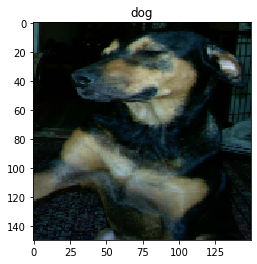

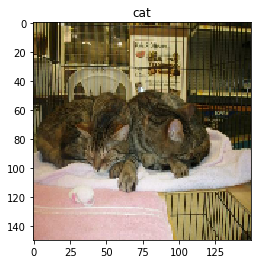

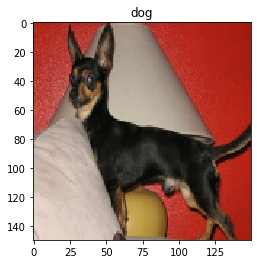

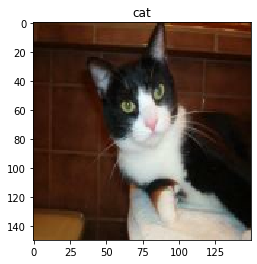

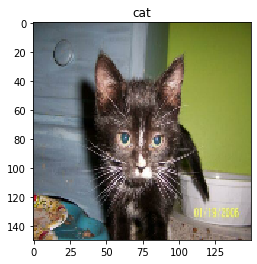

In [8]:
BATCH_SIZE = 64
IMG_HEIGHT = 150
IMG_WIDTH = 150
SHUFFLE_BUFFER_SIZE = 1000

#funcion para redimensionar imagenes
def format(image, label):
  image = tf.cast(image, tf.float32)
  image = image/255
  image = tf.image.resize(image, (IMG_HEIGHT, IMG_WIDTH))
  return image, label

#aplico redimensionamiento a los datos
train = raw_train.map(format)
validation = raw_validation.map(format)
test = raw_test.map(format)

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).repeat().batch(BATCH_SIZE)
validation_batches = validation.repeat().batch(SHUFFLE_BUFFER_SIZE)
test_batches = test.batch(SHUFFLE_BUFFER_SIZE)


get_label_name = info.features['label'].int2str
for image, label in train.take(5):
  plt.figure()
  plt.imshow(image)
  plt.title(get_label_name(label))


In [0]:
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)

In [10]:
model = Sequential()
#bloque 1
model.add(Conv2D(32, (3, 3), activation='sigmoid', input_shape=IMG_SHAPE))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64, (3, 3), activation='sigmoid', input_shape=IMG_SHAPE))
model.add(MaxPooling2D(2,2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 82944)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               10616960  
_________________________________________________________________
dense_1 (Dense)              (None, 100)               1

In [0]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [13]:
num_train, num_val, num_test = (
  info.splits['train'].num_examples*weight/10
  for weight in split
)

initial_epochs = 15

history = model.fit(train_batches,
                    steps_per_epoch = round(num_train)//BATCH_SIZE,
                    epochs=initial_epochs,
                    validation_data=validation_batches,
                    validation_steps=10)


Train for 290 steps, validate for 10 steps
Epoch 1/15
290/290 [==============================] - 73s 251ms/step - loss: 0.9780 - accuracy: 0.5055 - val_loss: 0.6932 - val_accuracy: 0.5015
Epoch 2/15
290/290 [==============================] - 72s 247ms/step - loss: 0.6914 - accuracy: 0.5282 - val_loss: 0.6857 - val_accuracy: 0.5612
Epoch 3/15
290/290 [==============================] - 74s 255ms/step - loss: 0.6867 - accuracy: 0.5459 - val_loss: 0.6846 - val_accuracy: 0.5635
Epoch 4/15
290/290 [==============================] - 74s 256ms/step - loss: 0.6842 - accuracy: 0.5591 - val_loss: 0.6840 - val_accuracy: 0.5387
Epoch 5/15
290/290 [==============================] - 75s 258ms/step - loss: 0.6826 - accuracy: 0.5593 - val_loss: 0.6871 - val_accuracy: 0.5451
Epoch 6/15
290/290 [==============================] - 75s 258ms/step - loss: 0.6806 - accuracy: 0.5673 - val_loss: 0.6841 - val_accuracy: 0.5547
Epoch 7/15
290/290 [==============================] - 73s 251ms/step - loss: 0.6791 - a

Se trabajo el modelo con loss='binary_crossentropy' ya que brindaba mejores resultados


**PRUEBA DEL MODELO**

In [14]:
print(train)
print(test)
print(raw_test)
print(test_batches)

<MapDataset shapes: ((150, 150, 3), ()), types: (tf.float32, tf.int64)>
<MapDataset shapes: ((150, 150, 3), ()), types: (tf.float32, tf.int64)>
<_OptionsDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<BatchDataset shapes: ((None, 150, 150, 3), (None,)), types: (tf.float32, tf.int64)>


In [0]:
results = model.evaluate(test_batches,verbose=0)

In [16]:
print('Test loss:', results[0])
print('Test accuracy:', results[1])

Test loss: 0.6570663253466288
Test accuracy: 0.5969828


In [17]:
predictions = model.predict_classes(test_batches, batch_size=None)
print('predictions shape:', predictions.shape)

predictions shape: (2320, 1)


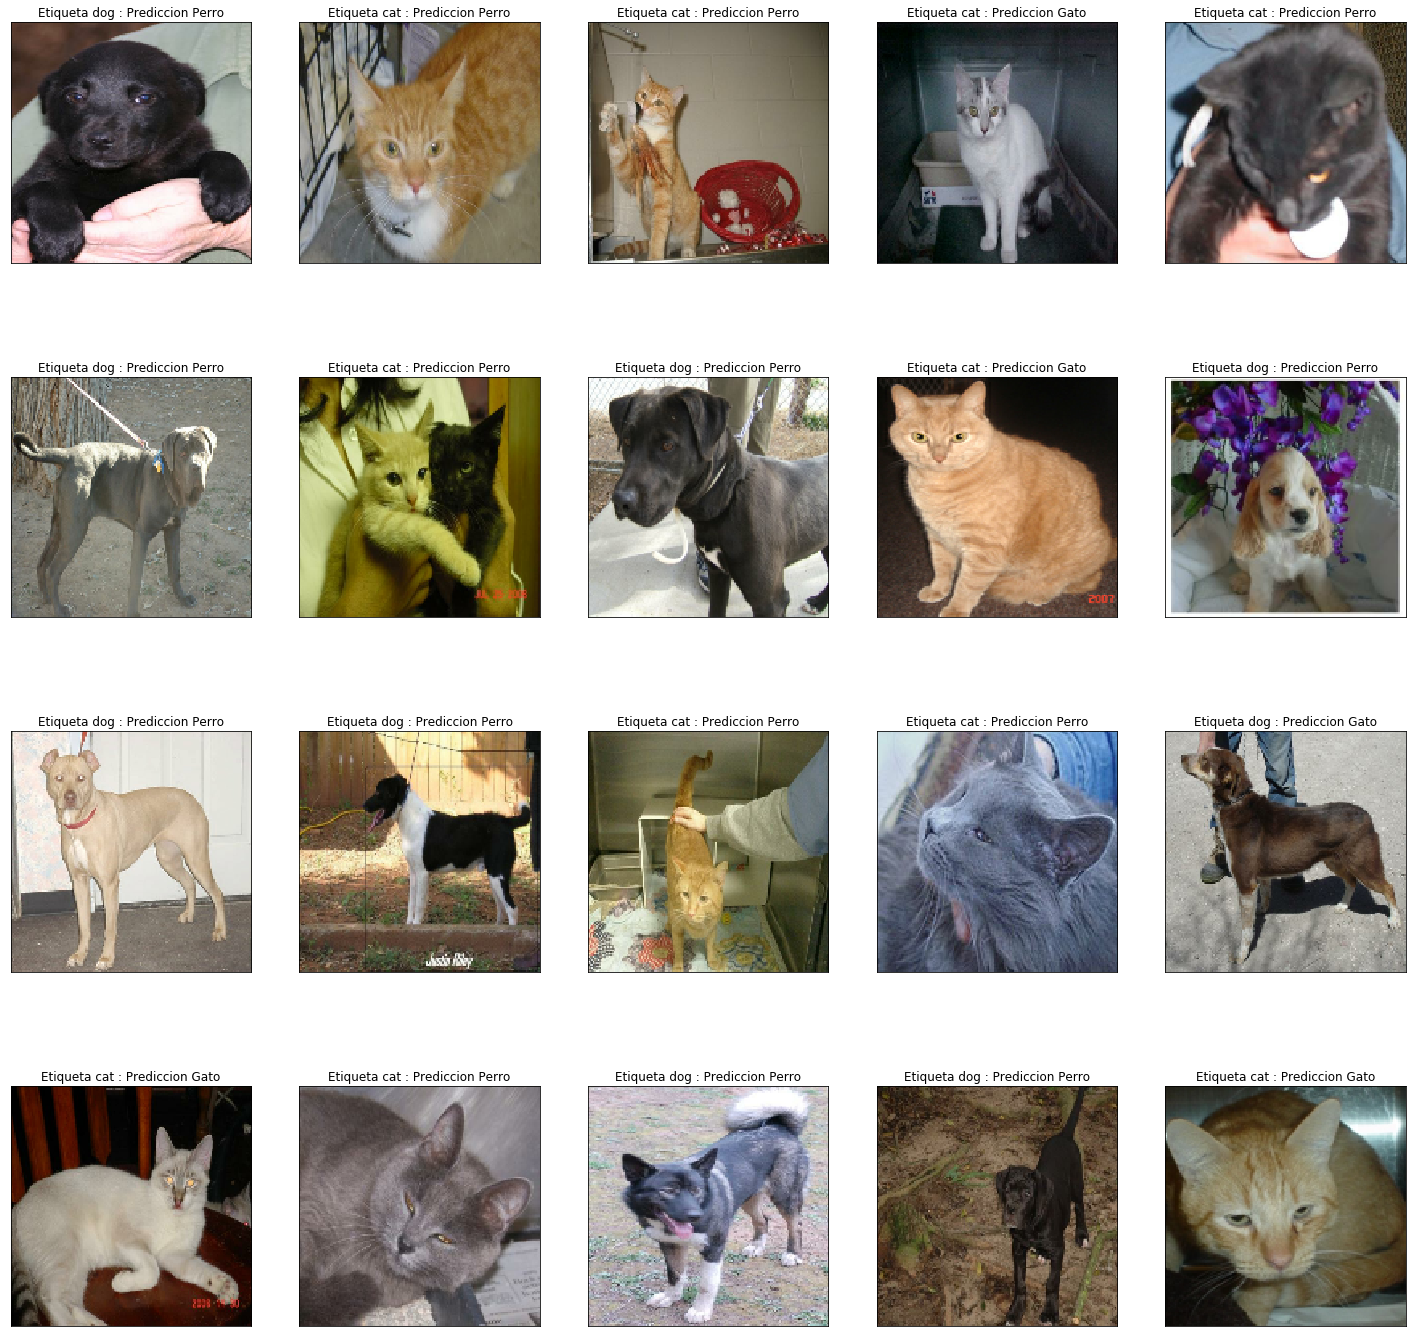

In [18]:
fig, axes = plt.subplots(4, 5, figsize=(25, 25), subplot_kw={'xticks': (), 'yticks': ()}) 
get_label_name = info.features['label'].int2str
classes = {0: 'Gato', 1: 'Perro'}
for image,pred,ax in zip(test.take(20),predictions,axes.ravel()):
  ax.imshow(image[0])
  ax.set_title("Etiqueta {} : Prediccion {}".format(get_label_name(image[1]), classes[pred[0]]))
